In [1]:
import sys
sys.path.append('../..')
from consecution import Node, Pipeline, GlobalState, Clock
from collections import namedtuple, defaultdict, Counter
import datetime
from dateutil.parser import parse
import glob
import csv
import itertools
from __future__ import print_function
import random
import numpy as np
import pandas as pd
import csv
from pprint import pprint
from pandashells import Timer

Person = namedtuple('Person', 'gender age spent')
Aggregate = namedtuple('Aggregate', 'kind total')


## Make Fake Data

In [2]:
def get_amount():
    return round(max([1, 30  + 5 * np.random.randn()]), 2)

def make_data(num=10):
    adult_ages = range(18, 80)
    child_ages = range(10, 18)
    genders = ['female', 'male'] * 10
    get_age_for = {
        'child': lambda: random.choice(child_ages),
        'adult': lambda: random.choice(adult_ages)
    }
    rec_list = []
    for nn in range(num):
        gender = random.choice(genders)
        age = get_age_for[random.choice(['adult', 'child']*10)]()
        spent = get_amount()
        rec_list.append((gender, age, spent))
    df = pd.DataFrame(rec_list, columns=['gender', 'age', 'spent'])
    return df

df = make_data(1000000)
df.to_csv('age_gender.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
print(df.head().to_csv(index=False))
    

gender,age,spent
female,55,30.07
male,64,40.45
male,14,29.14
female,67,34.42
female,17,29.09



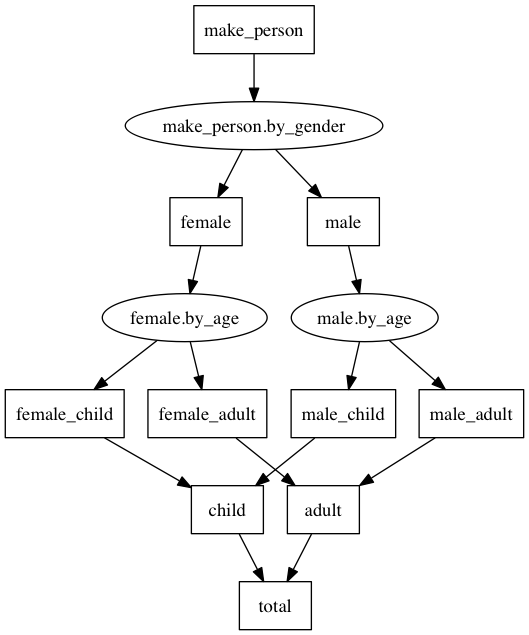


{'adult': 14993116.51,
 'child': 15004493.32,
 'female': 14982096.71,
 'female_adult': 7491472.43,
 'female_child': 7490624.28,
 'male': 15015513.12,
 'male_adult': 7501644.08,
 'male_child': 7513869.04,
 'total': 29997609.83}


In [3]:
# Named tuples are nice immutable containers 
# for passing data between nodes
Person = namedtuple('Person', 'gender age spent')

# Create a pipeline that aggregates by gender and age
# In creating the pipeline we focus on connectivity and don't
# worry about defining node behavior
def pipe_factory(Extractor, Agg, gender_router, age_router):

    pipe = Pipeline(
        Extractor('make_person') | 
        [
            (Agg('male') | [Agg('male_child'), Agg('male_adult'), age_router]),
            (Agg('female') | [Agg('female_child'), Agg('female_adult'), age_router]),
            gender_router
        ],
        global_state=GlobalState(segment_totals={})
    )

    # create and explicitly wire together extra nodes
    adult = Agg('adult')
    child = Agg('child')
    total = Agg('total')
    adult.add_downstream(total)
    child.add_downstream(total)

    # add new nodes into the pipeline
    pipe['male_child'].add_downstream(child)
    pipe['female_child'].add_downstream(child)
    pipe['male_adult'].add_downstream(adult)
    pipe['female_adult'].add_downstream(adult)

    return pipe

# Now we start writing node logic we want to use in the pipeline
# starting with a node to create a namedtuple from a csv row
class MakePerson(Node):
    def process(self, item):
        #item['age'] = int(item['age'])
        #item['spent'] = float(item['spent'])
        #print( '*'*80)
        #print (item)
        #print ('*'*80)
        self.push(Person(**item))

# Mutable global state is usually a bad idea, but we illustrate
# its use here in by using it to hold aggregate sums.
class Sum(Node):
    def begin(self):
        self.total = 0
    
    def process(self, item):
        self.total += item.spent
        self.push(item)
        
    def end(self):
        # when pipeline is done, update global state with sum
        self.global_state.segment_totals[self.name] = round(self.total, 2)

        
# define a gender-based route function
def by_gender(item):
    return '{}'.format(item.gender)

# define age-based route function
def by_age(item):
    if item.age >= 18:
        return '{}_adult'.format(item.gender)
    else:
        return '{}_child'.format(item.gender)

# instantiate a pipeline with the appropriate nodes
pipe = pipe_factory(MakePerson, Sum, by_gender, by_age)

# visualize pipeline
pipe.plot(notebook=True)

# process csv
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC, dialect="excel"))

# print summary information
print()
pprint(pipe.global_state.segment_totals)

In [ ]:
!pwd

In [4]:
with Timer('total'):
    with open('age_gender.csv') as f:
        pipe.consume(csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC, dialect="excel"))

__time__,time,tag
__time__,14.6705,total


In [10]:
with Timer('reading'):
    with open('age_gender.csv') as f:
        recs = [r for r in csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC, dialect="excel")]
with Timer('processing'):
    pipe.consume(recs)

__time__,4.900798,reading
__time__,8.434769,processing


In [12]:
print( len(recs))

1000000


In [ ]:
!pwd

In [ ]:
import pandas as pd

In [ ]:
with Timer('pandas'):
    df = pd.read_csv('./age_gender.csv')
    df["group"] = ["adult" if a>=18 else "child" for a in df.age]
    df = df.pivot_table(index="group", columns="gender", values="spent", margins=True, aggfunc=sum).fillna(0)
    print(df)

In [ ]:
ime cat examples/retail/age_gender.csv | p.df 'df["group"] = ["adult" if a>=18 else "child" for a in df.age]' |
p.df 'df.pivot_table(index="group", columns="gender", values="spent", margins=True, aggfunc=sum).fillna(0)' -o table index

In [ ]:
pipe.plot()